## Visualizing result from tensorboard. 
#### from tutorial: https://www.tensorflow.org/tensorboard/dataframe_api

#### The following packages are required:  
```
pip install tensorboard pandas
pip install matplotlib seaborn
```

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use(r"configs/paper_plot_style.mplstyle")
import seaborn as sns
import json
from scipy import stats
import os
import numpy as np

from pathlib import Path
%matplotlib inline

## Helper functions

In [50]:
def get_avg_per_uav(data):
    return 
def get_data(all_progress):

    # data_dict = {parameter: [] for parameter in parameter_list}
    data_dict = {}

    for progress in all_progress:
        with open(str(progress.absolute()), "r") as f:
            try:
                data = json.loads(f.readlines()[-1])
            except Exception as e:
                f.seek(0)
                # data = json.loads(f.readlines()[-2])
                print(f"error reading {progress.absolute()} skipping.")
                continue
            data["target_v"] = data["env_config"]["target_v"]
            # data["safe_action"] = data["env_config"]["use_safe_action"]
            data["safe_action"] = data["exp_config"]["safe_action_type"]
            data["num_obs"] = data["env_config"]["num_obstacles"]
            data["seed"] = data["env_config"]["seed"]
            data["uav_done"] = np.average(data["uav_done"], axis=1).sum()
            uav_done_time = np.nan_to_num(np.array(data["uav_done_time"], dtype=np.float64), nan=100)
            # print(uav_done_time)
            data["uav_done_time"] = np.nanmean(uav_done_time)
            for k, v in data.items():
                if k not in data_dict:
                    data_dict[k] = []
                data_dict[k].append(v)
            data_dict['file_name'] = progress.absolute()
            
    df = pd.DataFrame(data_dict)
    return df
                    

In [51]:

# EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-05-28-00-55_a8086c4'
# EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-05-28-04-07_a2422f9'
EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-09-03-13-59_698e108'
EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-09-03-14-04_698e108'
EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-09-03-14-14_698e108'


basedir_path = Path(EXP_FOLDER)
basedir_list = list(basedir_path.glob("**/result.json"))
image_folder = basedir_path / "images"

if not image_folder.exists():
    image_folder.mkdir(parents=True,exist_ok=True)

df = get_data(basedir_list)
df.head

<bound method NDFrame.head of    num_episodes  uav_collision  obs_collision  uav_done  uav_done_time  \
0             2            0.0            2.0       4.0        18.8750   
1             2            0.0            0.0       4.0        19.0875   
2             2            0.0            2.0       4.0        18.7875   
3             2            0.0            2.0       4.0        18.8750   
4             2            0.0            2.0       4.0        18.7875   

                               episode_time  \
0                              [19.1, 19.1]   
1  [19.900000000000013, 19.900000000000013]   
2                 [19.70000000000001, 18.9]   
3                              [19.1, 19.1]   
4                 [19.70000000000001, 18.9]   

                                        episode_data  \
0  {'time_step_list': [[[0.0, 0.1, 0.2, 0.3000000...   
1  {'time_step_list': [[[0.0, 0.1, 0.2, 0.3000000...   
2  {'time_step_list': [[[0.0, 0.1, 0.2, 0.3000000...   
3  {'time_step_lis

<AxesSubplot: xlabel='num_obs', ylabel='uav_done_time'>

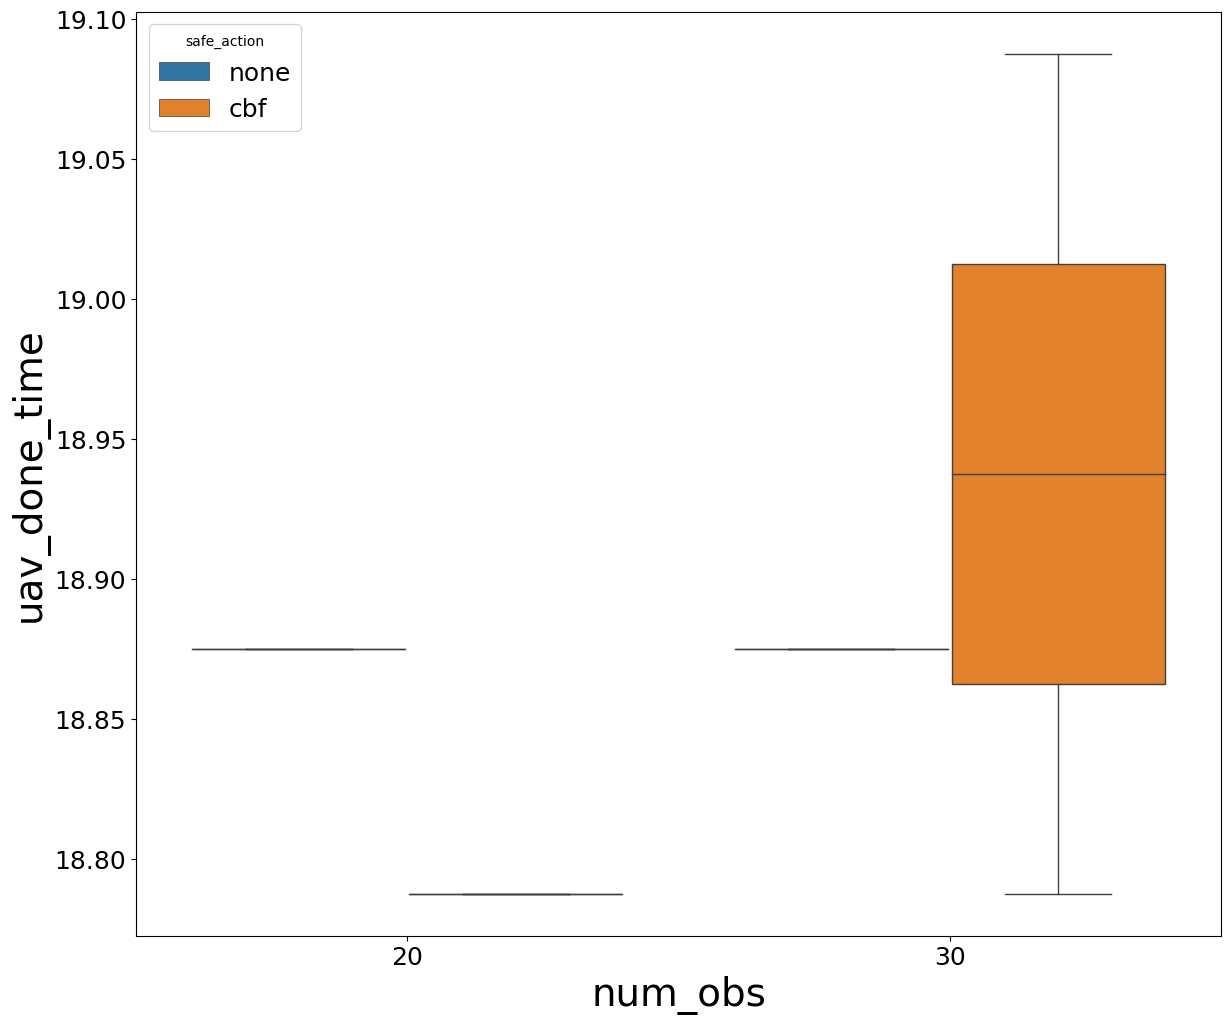

In [52]:

sns.boxplot(df, x="num_obs", y="uav_done_time", hue="safe_action")

In [53]:
obs_group = df.groupby(["num_obs", "safe_action"])
obs_group.groups.keys()


dict_keys([(20, 'cbf'), (20, 'none'), (30, 'cbf'), (30, 'none')])

In [54]:
from math import nan


obs_group.get_group((20, "none")).uav_done_time


3    18.875
Name: uav_done_time, dtype: float64

In [55]:
# nominal parameters
NUM_PURSUERS = 4
NUM_OBSTACLES = 6
OBSERVATION_RADIUS = 20

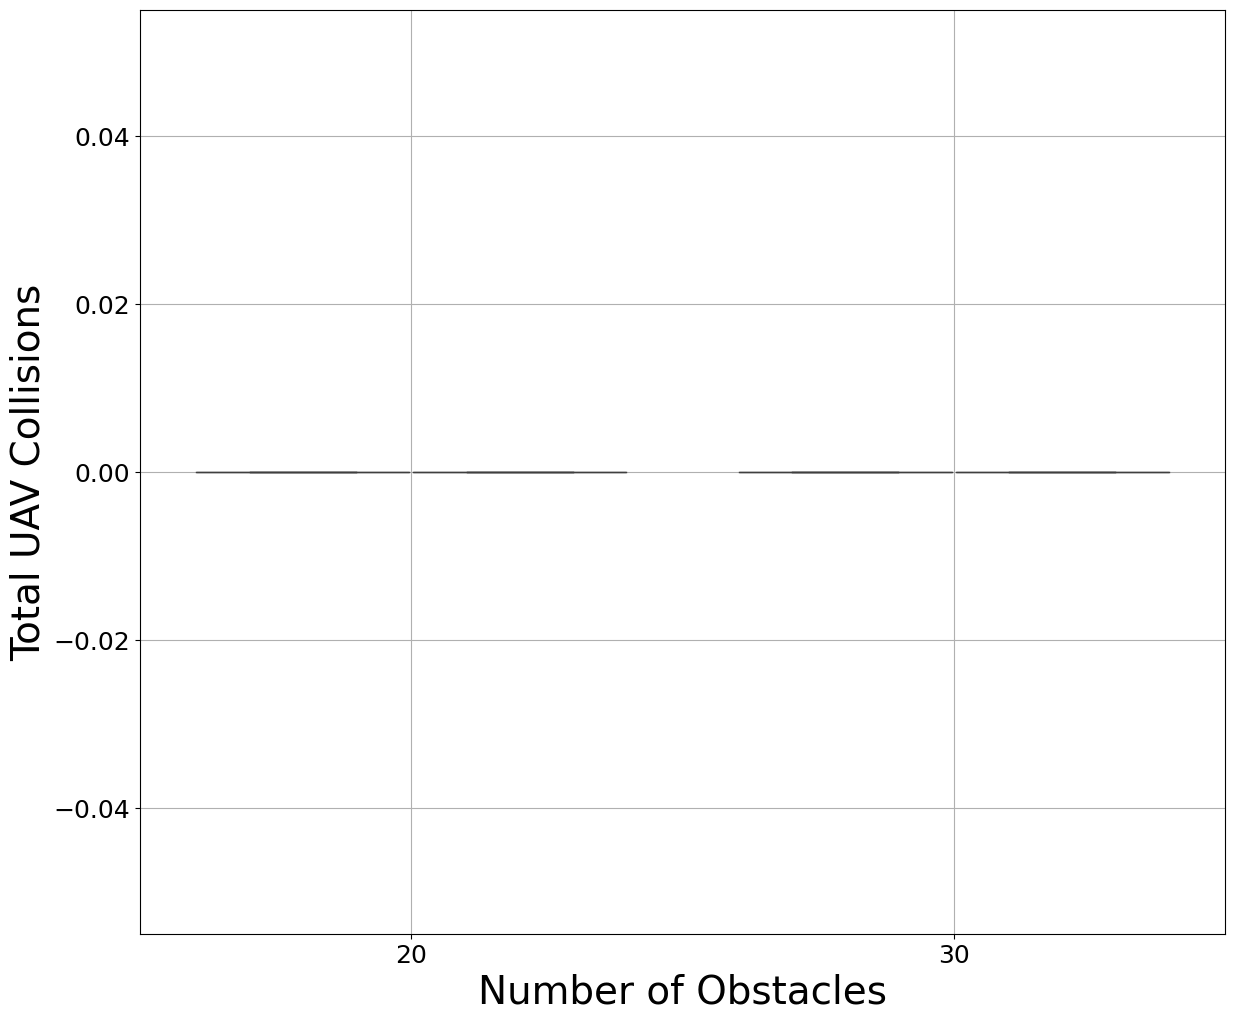

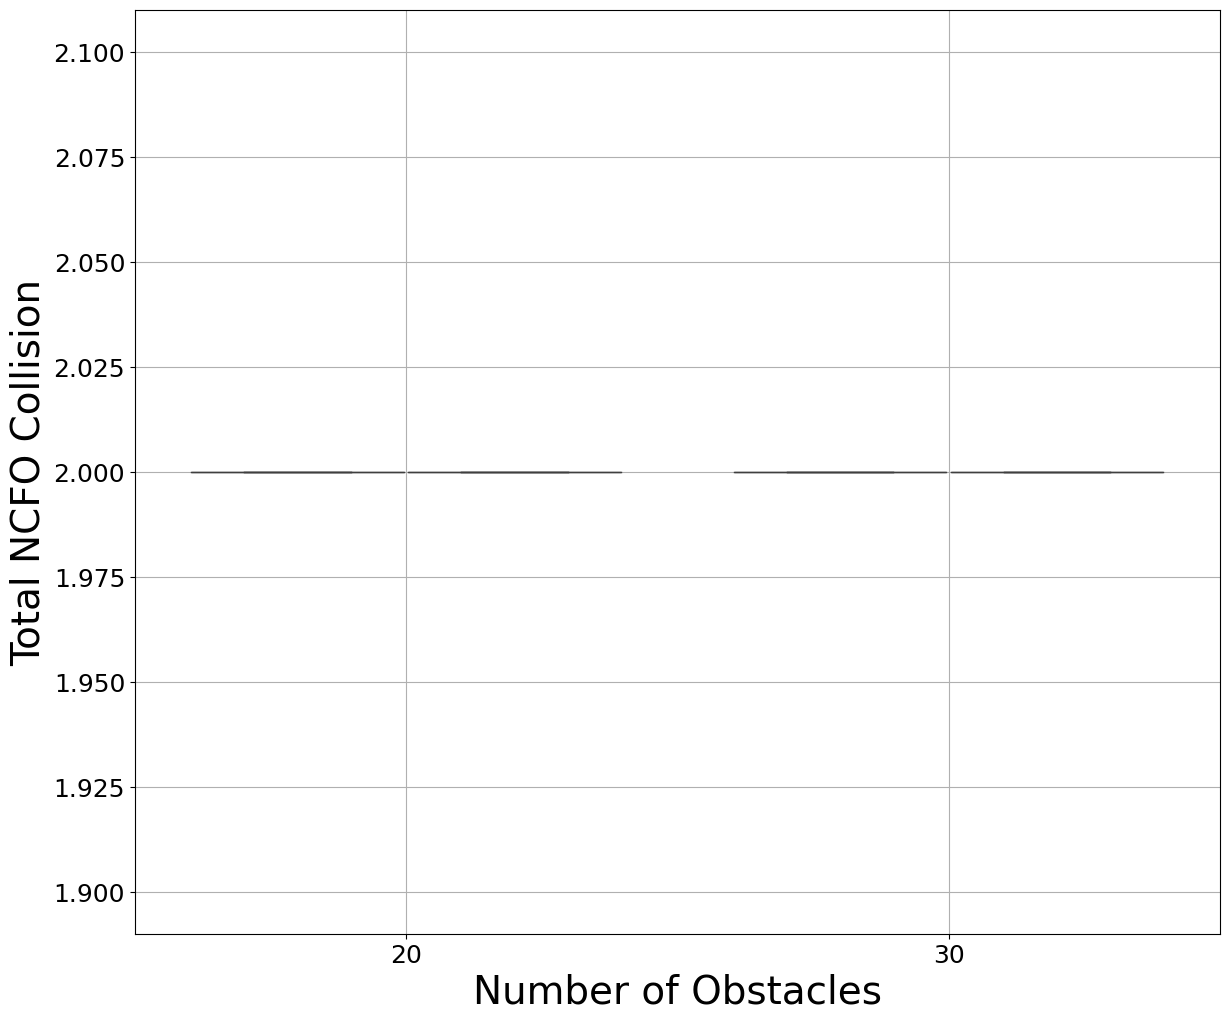

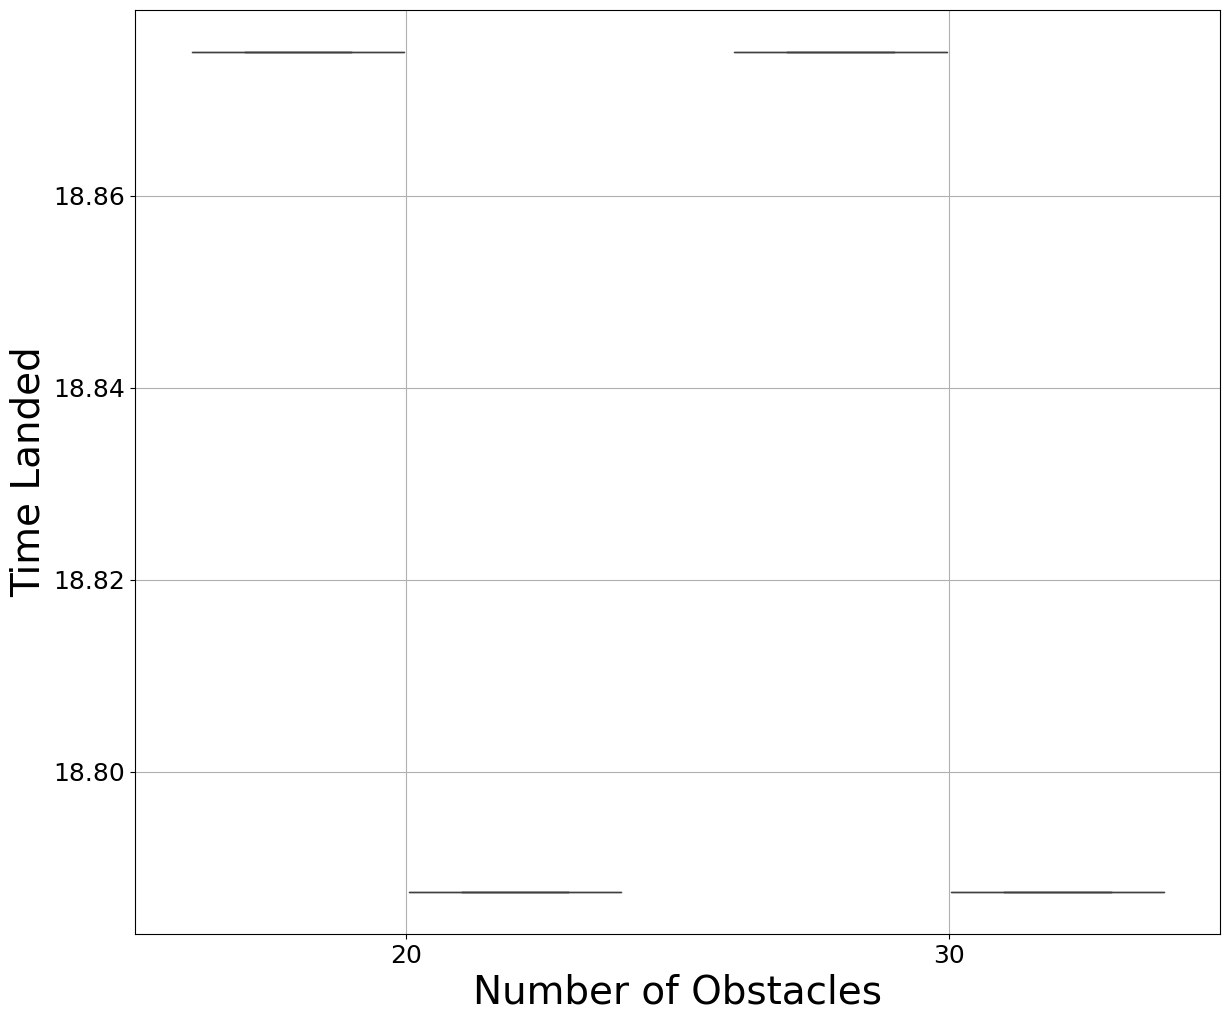

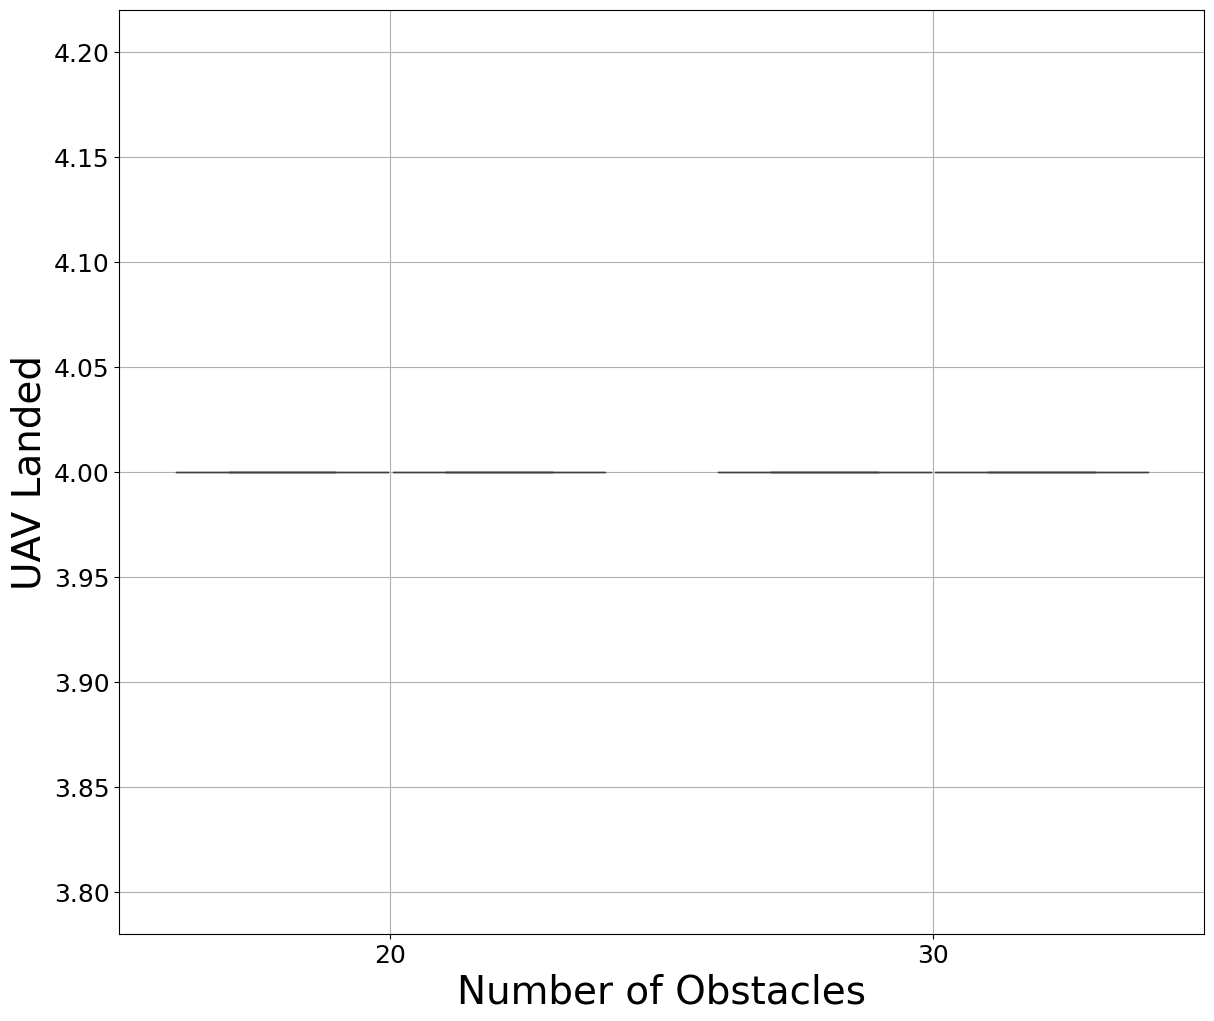

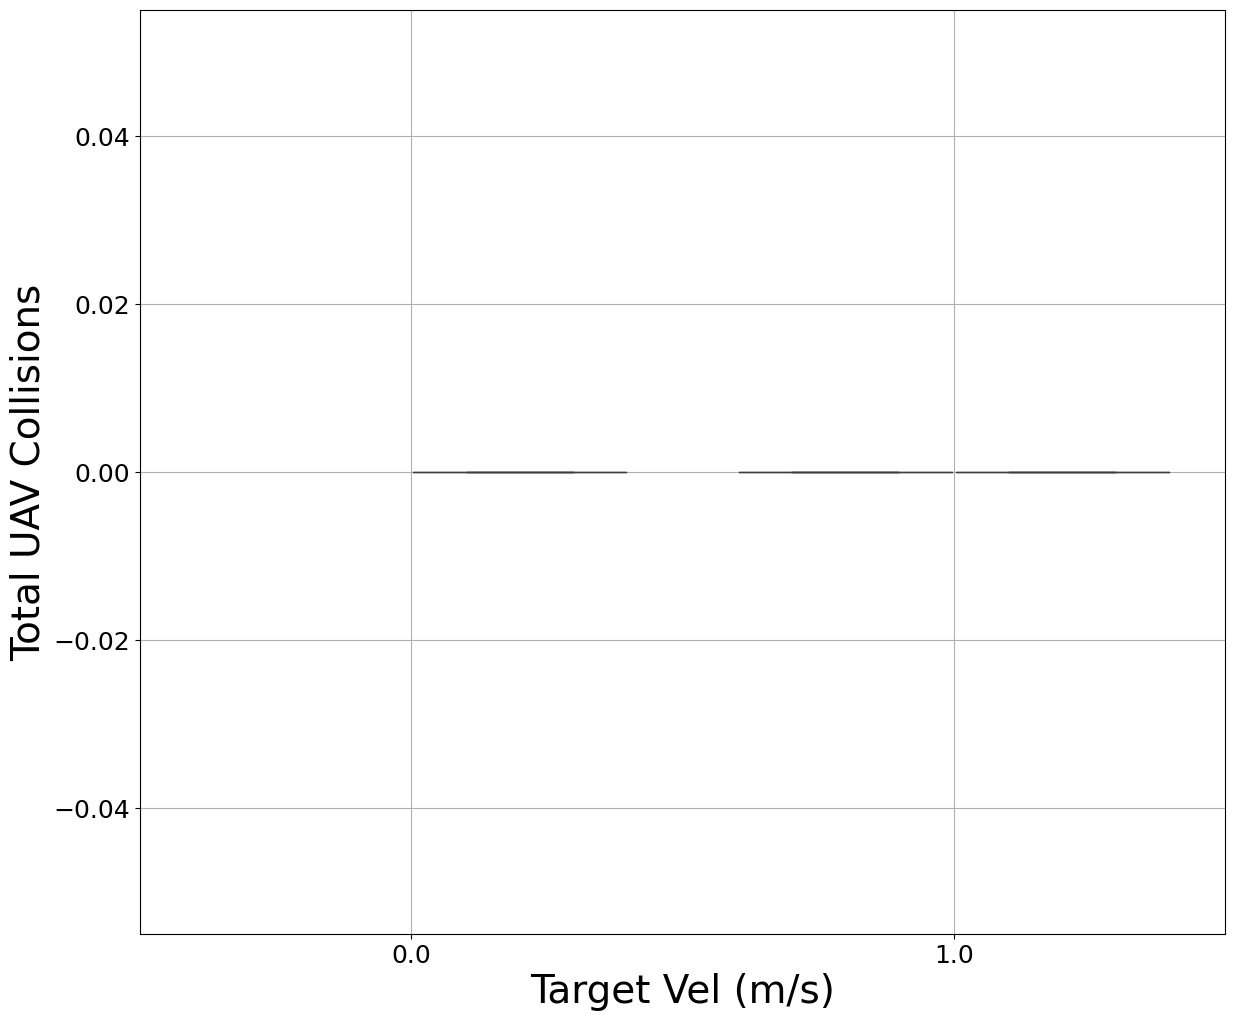

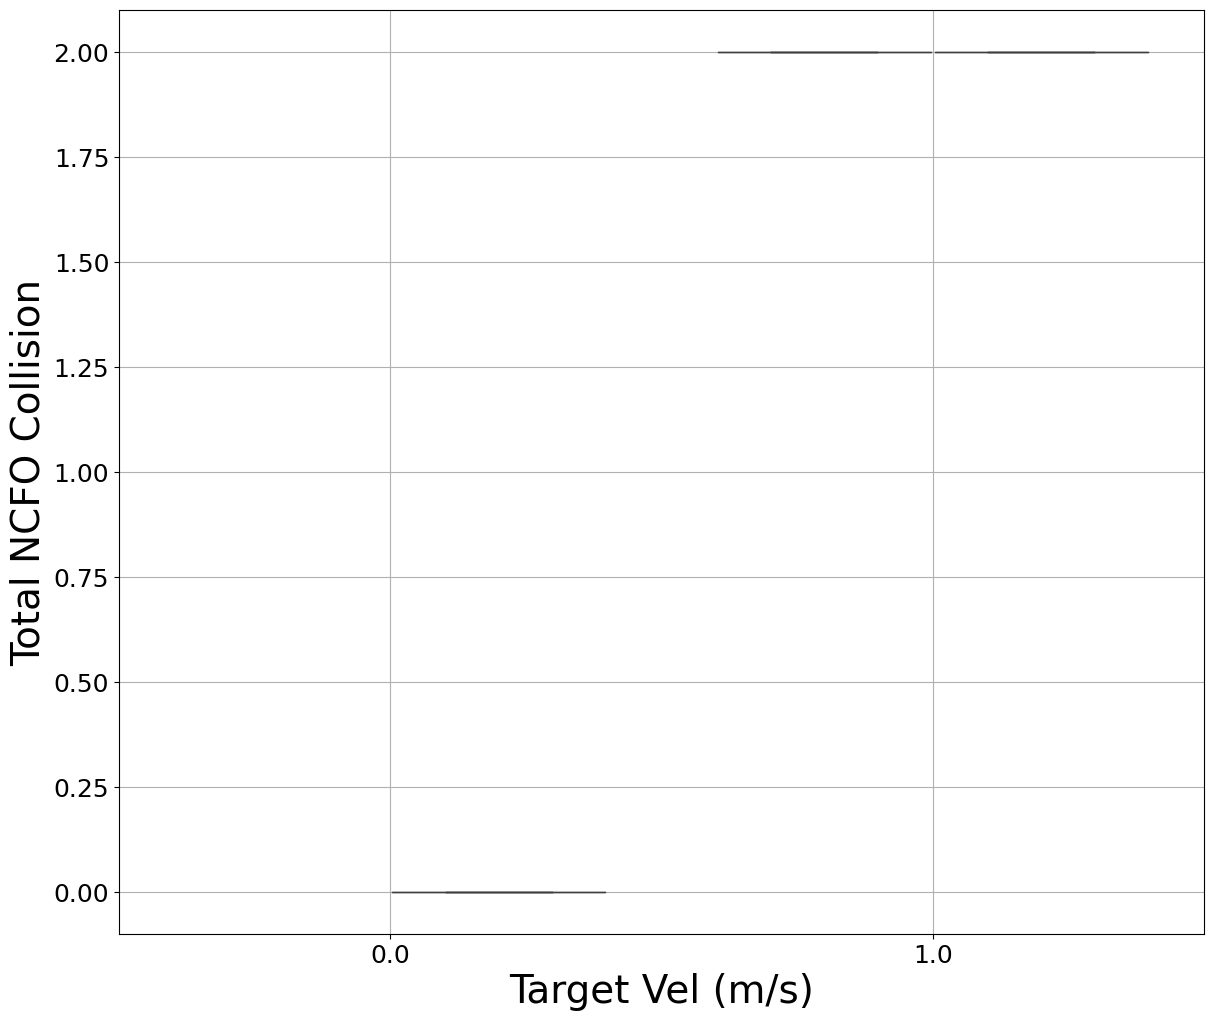

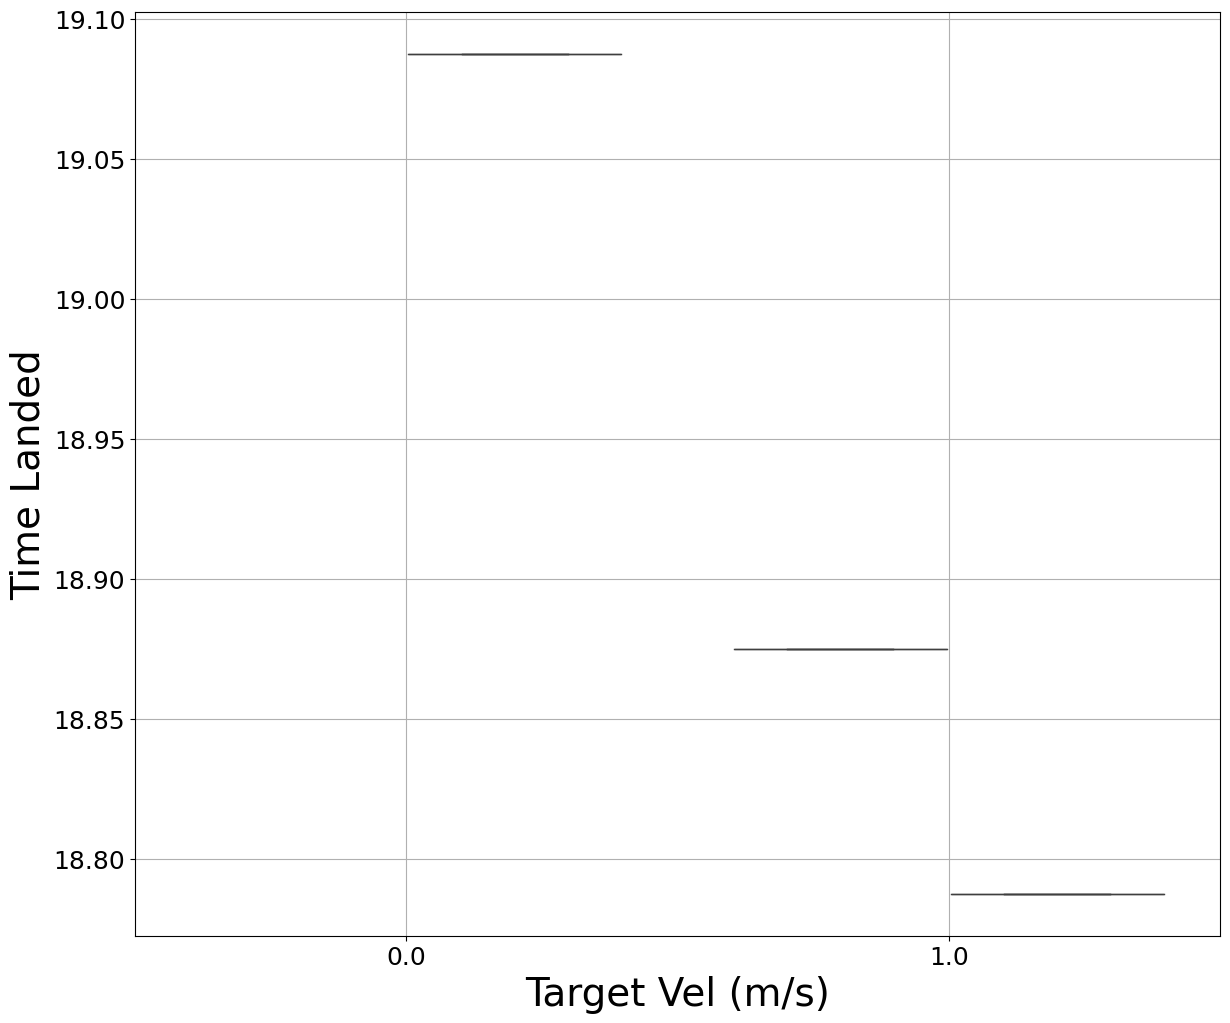

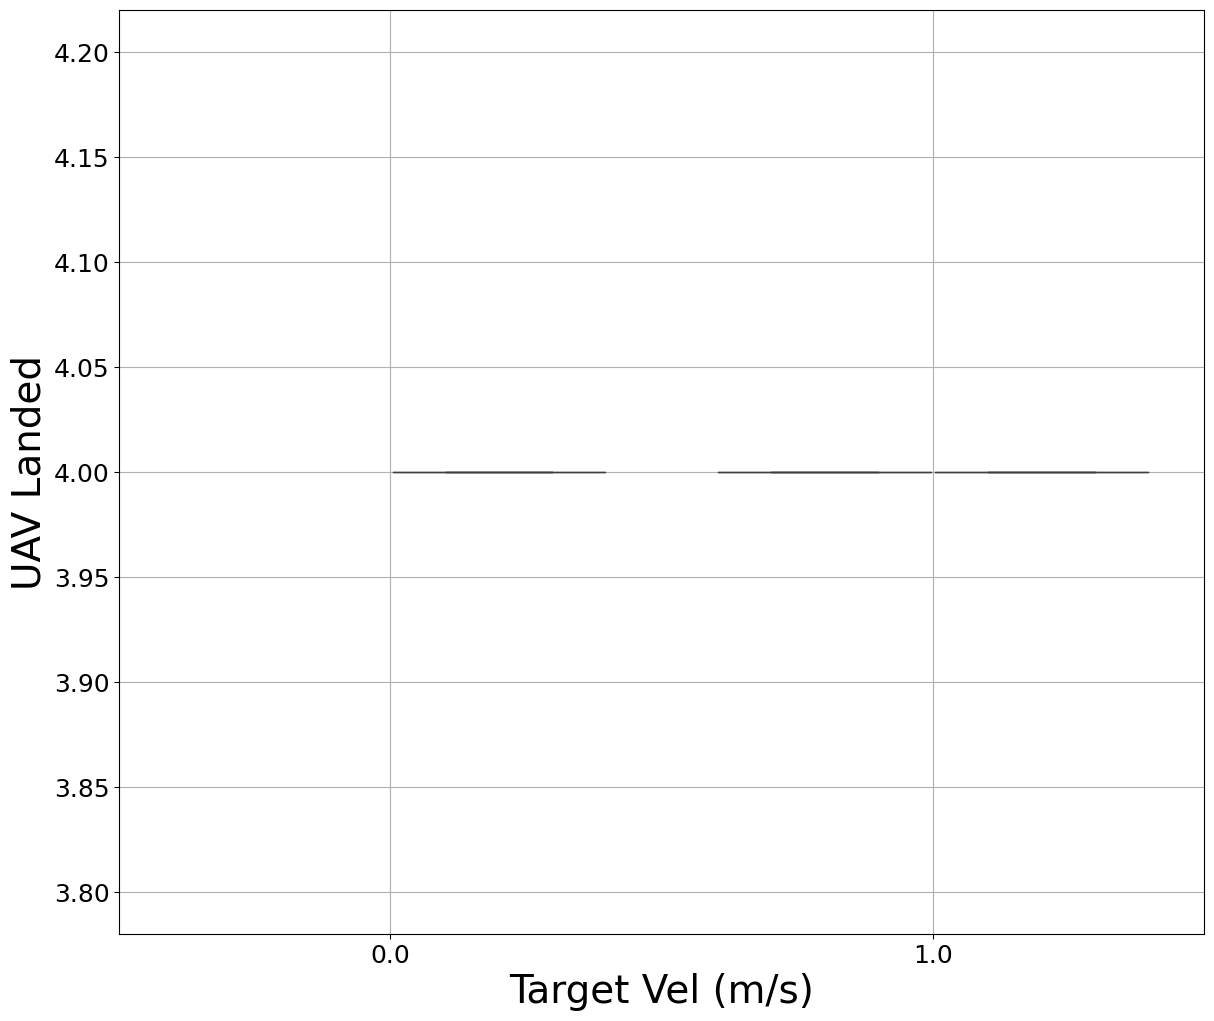

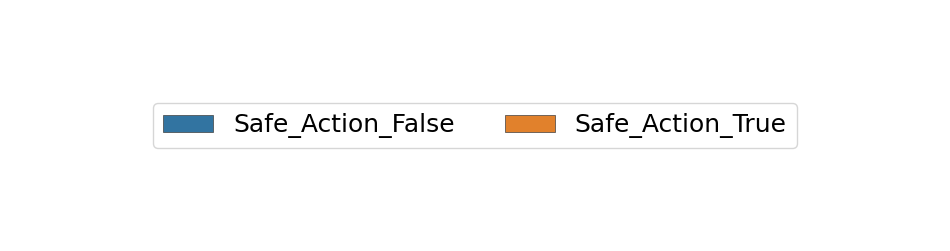

In [56]:
from numpy import imag


groups_to_plot = [
    {
        "group": df.groupby(["target_v"]),
        "group_x": "num_obs",
        "group_key": (1),
        "group_title": "vary_safe_action_tgt_v_1",
        "x_label": "Number of Obstacles",
    },
    {
        "group": df.groupby(["num_obs"]),
        "group_x": "target_v",
        "group_key": (30),
        "group_title": "vary_safe_action_obs_30",
        "x_label": "Target Vel (m/s)",
    },
    # {
    #     "group": df.groupby(["num_obs"]),
    #     "group_x": "safe_action",
    #     "group_key": (30),
    #     "group_title": "fix_obs_vary_pursuer",
    #     "x_label": "Use Safe Layer",
    # },
    # {
    #     "group": df.groupby(["num_pursuers", "observation_radius"]),
    #     "group_x": "num_obstacles",
    #     "group_key": (NUM_PURSUERS, OBSERVATION_RADIUS),
    #     "group_title": "fix_pursuers_vary_obs",
    #     "x_label": "Number of Obstacles",
    # },
    # {
    #     "group": df.groupby(["observation_radius"]),
    #     "group_x": "num_pursuers",
    #     "group_key": (OBSERVATION_RADIUS),
    #     "group_title": "fix_obs_vary_pursuer_all",
    #     "x_label": "Number of Pursuers",
    # },
]

# items_to_plot =[ 'evader_captured', 'episode_reward', 'obstacle_collisions','target_collisions', 'target_breached', 'agent_collisions', 'time_total_s', 'timesteps_total']
items_to_plot = {
    "uav_collision": "Total UAV Collisions",
    "obs_collision": "Total NCFO Collision",
    "uav_done_time": "Time Landed",
    "uav_done": "UAV Landed"
    # "evader_captured": "Total Evader Captured",
    # "episode_reward": "Episode Reward",
    # "obstacle_collisions": "Total Pursuer/NCIE Collisions",
    # "target_collisions": "Total Pursuer/Target Collisions",
    # "target_breached": "Total Target Breached",
    # "agent_collisions": "Total Puruser Collisions",
    # "time_total_s": "Total Time (s)",
    # "timesteps_total": "Time Steps Total",
    # "cumulative_episode_reward": "Total Reward",
}

sns.color_palette("colorblind")

labels_to_plot = ["Safe_Action_False", "Safe_Action_True"]

def plot_groups(groups, items, plot_type="box"):
    if plot_type == "bar":
        plot_func = sns.barplot
    elif plot_type == "box":
        plot_func = sns.boxplot
    else:
        raise NameError("unknown plot_type")
    for group in groups:
        for key, value in items.items():
            # fig, ax = plt.subplots(figsize=(12, 10))
            fig, ax = plt.subplots()
            # ax.set_prop_cycle('color', sns.color_palette("colorblind",len(labels_to_plot)))
            # ax.set_prop_cycle('color', sns.color_palette("tab10",len(labels_to_plot)))
            # print(f'group_key{group["group_key"]}')
            group_to_plot = group["group"].get_group(group["group_key"])
            # group_to_plot.safe_action = group_to_plot.safe_action.astype("category")
            # # group_to_plot.checkpoint = group_to_plot.checkpoint.astype("category")
            # group_to_plot.safe_action = group_to_plot.safe_action.cat.set_categories(
            #     labels_to_plot
            # )
            ax = plot_func(
                group_to_plot, hue="safe_action", x=group["group_x"], y=key, ax=ax
            )
            ax.set_ylabel(value)
            ax.set_xlabel(group["x_label"])
            # if item == "episode_reward":
            #     ax.invert_yaxis()
            ax.grid()
            # ax.legend()
            # don't plot legends here. see below
            ax.legend_.remove()

            fig.savefig(os.path.join(image_folder,f"img_{plot_type}_{group['group_title']}_{key}.png"))

    # We're going to create a separate figure with legends.
    # https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
    # then create a new image
    # adjust the figure size as necessary
    figsize = (12, 3)
    fig_leg = plt.figure(figsize=figsize)
    ax_leg = fig_leg.add_subplot(111)
    # add the legend from the previous axes
    handles, labels = ax.get_legend_handles_labels()
    ax_leg.legend(handles, labels_to_plot, loc="center", ncol=3)
    # ax_leg.legend(["Safe_True", "safe_false"], loc="center", ncol=3)
    # hide the axes frame and the x/y labels
    ax_leg.axis("off")
    fig_leg.savefig(os.path.join(image_folder, 'plt_label.png'))


plot_groups(groups_to_plot, items_to_plot)
# plot_groups(groups_to_plot, items_to_plot, plot_type="box")


In [57]:
obs_group = df.groupby(["seed", "num_obs", "safe_action", "target_v"])
obs_group.groups.keys()

dict_keys([(173, 20, 'cbf', 1.0), (173, 20, 'none', 1.0), (173, 30, 'cbf', 0.0), (173, 30, 'cbf', 1.0), (173, 30, 'none', 1.0)])

In [62]:
safe_action = [False, True]
safe_action = ["none", 'cbf']
target_v = [1.0]

groups_to_plot = []
for action in safe_action:
    for v in target_v:
        groups_to_plot.append((173, 30, action, v))

groups_to_plot
        

[(173, 30, 'none', 1.0), (173, 30, 'cbf', 1.0)]

In [63]:

data = obs_group.get_group(groups_to_plot[0])["episode_data"]
data.keys()

Int64Index([0], dtype='int64')

key: 0
group: (173, 30, 'none', 1.0)


ValueError: invalid literal for int() with base 10: 'none'

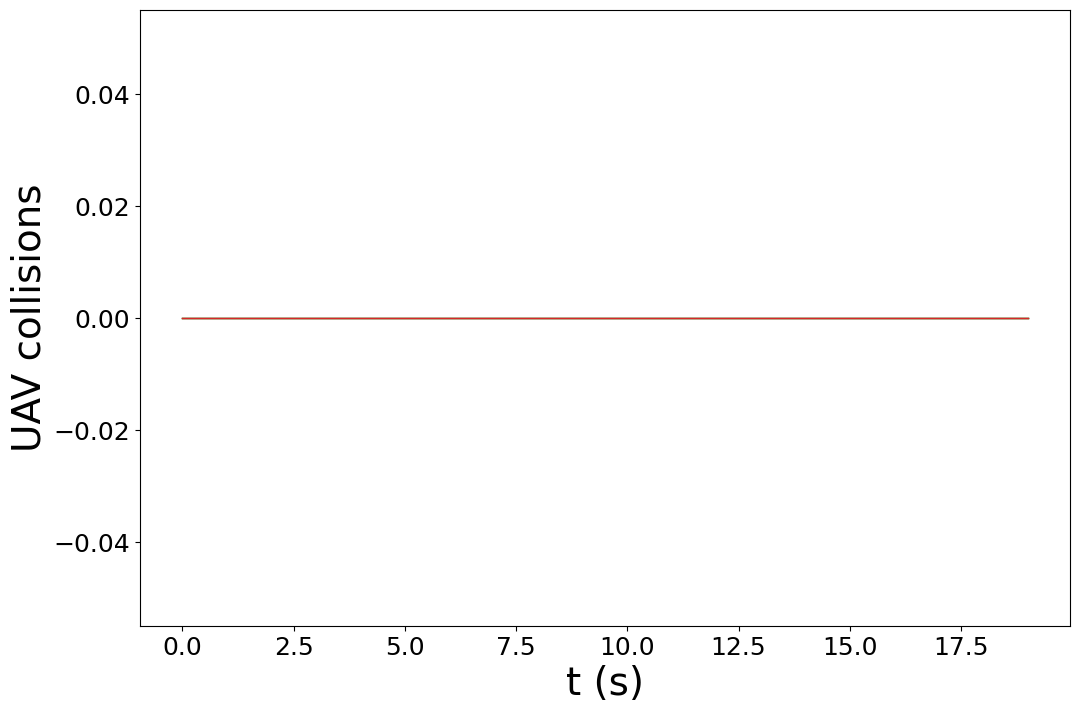

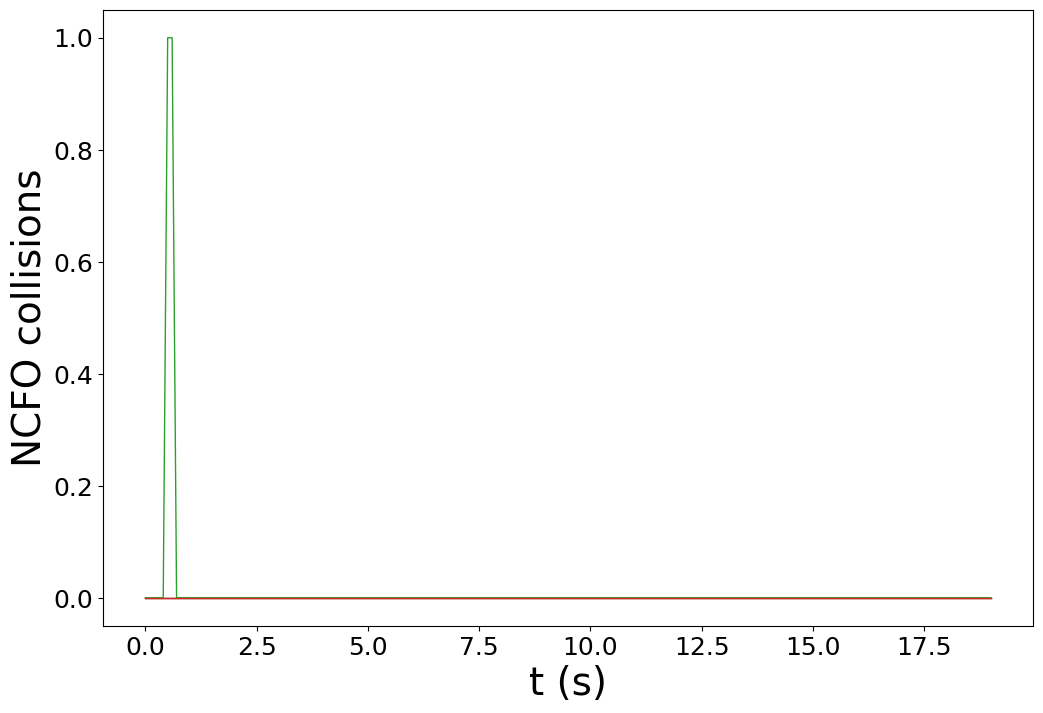

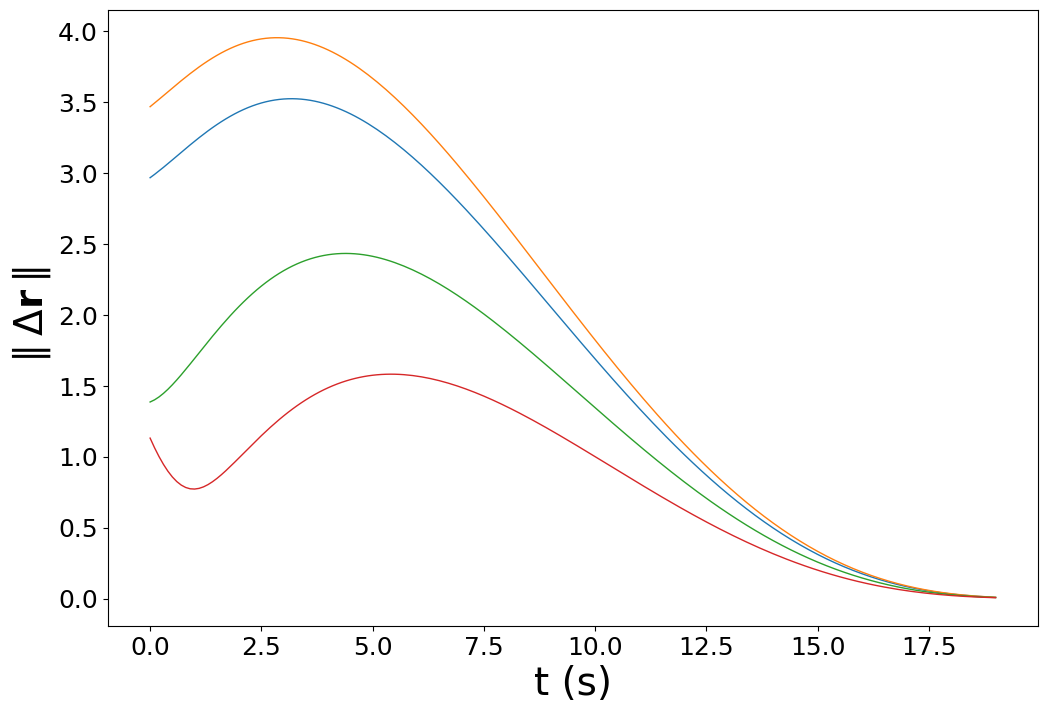

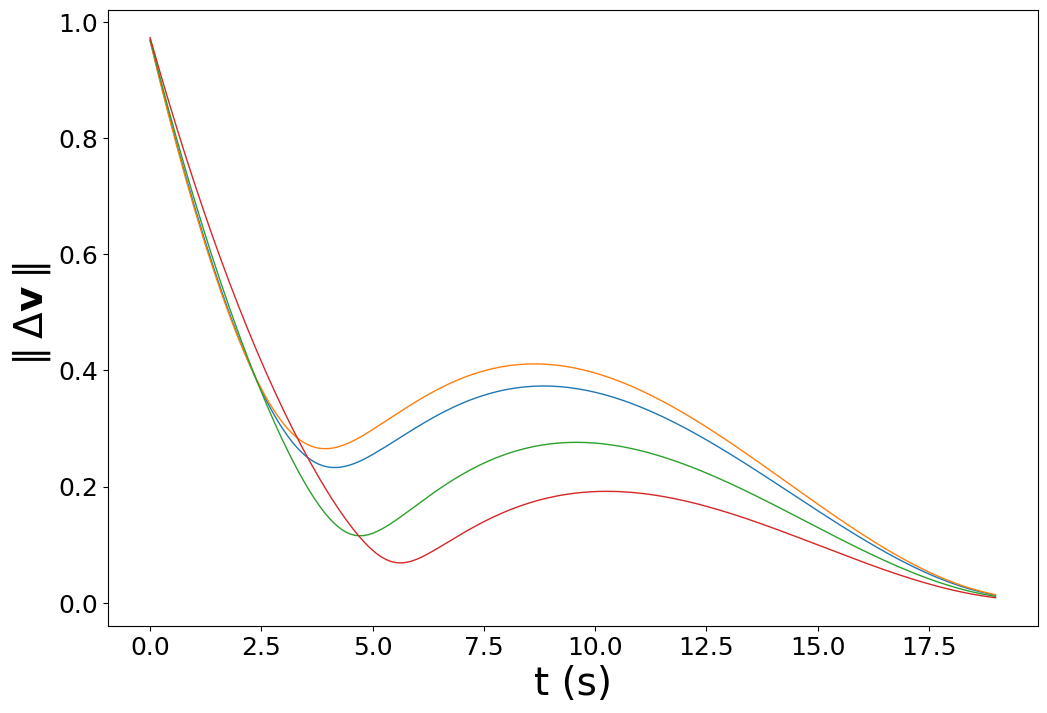

In [64]:

num_uavs = 4
for group_to_plot in groups_to_plot:
    data_group = obs_group.get_group(group_to_plot)["episode_data"]
    key = [key for key in data_group.keys()][0]
    print(f"key: {key}")
    print(f"group: {group_to_plot}")
    data = data_group[key]

    time_step_list = np.array(data['time_step_list'][0])
    uav_collision_list = np.array(data['uav_collision_list'][0])
    obstacle_collision_list = np.array(data['obstacle_collision_list'][0])
    rel_pad_dist = np.array(data['rel_pad_dist'][0])
    rel_pad_vel = np.array(data['rel_pad_vel'][0])

    all_axes = []
    all_figs = []
    for i in range(4):
        fig = plt.figure(figsize=(12, 8))
        all_axes.append(fig.add_subplot(111))
        all_figs.append(fig)
    # all_axes.append(fig.add_subplot(121))
    # all_axes.append(fig.add_subplot(122))
    # all_figs.append(fig)


    # fig = plt.figure(figsize=(12, 6))
    # fig.tight_layout()
    # fig.subplots_adjust(wspace=0.35)
    # all_axes.append(fig.add_subplot(121))
    # all_axes.append(fig.add_subplot(122))
    # all_figs.append(fig)

    for idx in range(num_uavs):
        all_axes[0].plot(
            time_step_list[idx],
            uav_collision_list[idx],
            label=f"uav_{idx}",
        )
        all_axes[1].plot(
            time_step_list[idx],
            obstacle_collision_list[idx],
            label=f"uav_{idx}",
        )
        all_axes[2].plot(
            time_step_list[idx],
            rel_pad_dist[idx],
            label=f"uav_{idx}",
        )
        all_axes[3].plot(
            time_step_list[idx],
            rel_pad_vel[idx],
            label=f"uav_{idx}",
        )

    all_axes[0].set_ylabel("UAV collisions")
    all_axes[1].set_ylabel("NCFO collisions")
    all_axes[2].set_ylabel("$\parallel \Delta \mathbf{r} \parallel$")
    all_axes[3].set_ylabel("$\parallel \Delta \mathbf{v} \parallel$")

    for ax_ in all_axes:
        ax_.set_xlabel("t (s)")


    plt_prefix = {
        "seed": group_to_plot[0],
        "obs": group_to_plot[1],
        "sa": group_to_plot[2],
        "tgt_v": group_to_plot[3],
    }

    plt_prefix = "_".join([f"{k}_{str(int(v))}" for k, v in plt_prefix.items()])

    suffixes = ["uav_col.png", "ncfo_col.png", "r_time.png", "v_time.png"]

    for fig_, suffix in zip(all_figs, suffixes):
        file_name = image_folder / f"{plt_prefix}_{suffix}"
        fig_.savefig(file_name)
        plt.close(fig_)


figsize = (10, 3)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
handles, labels = all_axes[0].get_legend_handles_labels()
ax_leg.legend(handles, [f"UAV {idx}" for idx in range(num_uavs)], loc="center", ncol=4)
# hide the axes frame and the x/y labels
ax_leg.axis("off")
fig_leg.savefig(image_folder / "uav_labels.png")

plt.show()

